In [220]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [213]:
sns.set(style="whitegrid", palette="muted", color_codes=True)

In [ ]:
df = pd.read_csv("../data/train.csv")

### EDA

In [ ]:
#1. Check shape of dataset — Understand rows/columns count → Helps estimate dataset size.
def explore_shapes(df)->None:
    shapes = df.shape
    print(f"rows : {shapes[0]}")
    print(f"columns : {shapes[1]}")

In [ ]:
#2. List all columns and data types — Identify numeric, categorical, date, and text features → Plan preprocessing.
def explore_types(df) -> dict:
    types = df.dtypes.value_counts().to_dict()
    for i,k in types.items():
        print(f"Total {k} of column type : {i}")
    type_to_column = {}
    for i,k in types.items():
        type_to_column[str(i)] = df.select_dtypes(include=[i]).columns.tolist()
    return type_to_column

In [ ]:
# 3. Check null or missing values — Detect data quality issues → Plan imputation/removal.
def explore_null_or_missing(df:pd.DataFrame, type_to_column : dict)->tuple[pd.DataFrame, pd.DataFrame]:
    """
        Analyze and summarize missing (null) values in a dataset at both the *column level*
        Returns two summary DataFrames at column type level and column level:

    """
    numberOfRecord = len(df)
    columnLevelSummary = []
    typeLevelSummary = []
    for t, collist in type_to_column.items():
        numberOfcolumns = len(collist)
        missing = df[collist].isnull().sum()
        missing = missing[missing> 0]
        if len(missing) > 0:
            missing = missing.to_dict()
            typeLevelSummary.append({"column_type" : t, "column_with_missing_values" : len(missing), "total_columns" : numberOfcolumns, "percentage" : round(len(missing)/numberOfcolumns * 100, 2)})
            for col,v in missing.items():
                columnLevelSummary.append({"column_type" : t, "column" : col, "missing_record" : v, "total_record" : numberOfRecord, "percentage" : round(v/numberOfRecord * 100, 2)})


    typeLevelSummary = pd.DataFrame(typeLevelSummary)
    columnLevelSummary = pd.DataFrame(columnLevelSummary)
    return typeLevelSummary, columnLevelSummary

In [ ]:
# 4. Check duplicate rows — Identify redundancy → Clean data.
def explore_duplicates(df : pd.DataFrame) -> None:
    """
    It returns true but it prints the number 
    """
    isduplicate = df.duplicated().any()
    if isduplicate:
        print(f"Number of Duplicate records -> {df.duplicated().sum()}")
    else:
        print("No duplicate records Found")

In [ ]:
# 5. Check unique values per column — Understand feature variety → Find categorical vs continuous.
def explore_unique_values(df : pd.DataFrame, type_to_column : dict):
    feature_summary = []
    for t, collist in type_to_column.items():
        unique_values = df[collist].nunique()
        for col, val in unique_values.items():    
            feature_summary.append(
                {'type' : t, 'column' : col, 'unique_count':val}
            )
    summarydf = pd.DataFrame(feature_summary)
    summarydf = summarydf.sort_values(by="unique_count", ascending=False).reset_index(drop=True)
    return summarydf

In [202]:
#6. Check constant columns — Detect uninformative features → Drop them.
def explore_constant_columns(df : pd.DataFrame) -> None:
    newdf = df[df['unique_count'] == 1]
    return newdf['column'].to_list()

## Univariate Analysis 

In [256]:
#7. Histogram of numerical columns — See distribution shape → Detect skewness/outliers.
def explore_univariate_skewness_outliers_histplots(df : pd.DataFrame, type_to_column)->None:
    numericalcols = []
    for t, collist in type_to_column.items():
        if t != 'object':
            numericalcols.extend(collist)
    n = len(numericalcols)
    cols = min(5, n)
    rows = math.ceil(n/5)
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))

    fig.suptitle("Hist plots of numerical columns (check outliers & skewness)", fontsize=26, weight="bold", y=1.05)
    axes = axes.flatten() if n > 1 else [axes]
    for i, col in enumerate(numericalcols):
        series = df[col]
        n_data = len(series)
        q25, q75 = np.percentile(series, [25, 75])
        iqr = q75 - q25
        bin_width = 2 * iqr * (n_data ** (-1/3))
        if bin_width > 0:
            bins = int(np.ceil((series.max() - series.min()) / bin_width))
        else:
            bins = int(np.ceil(math.log2(n_data) + 1))  # fallback: Sturges rule
        bins = max(10, min(bins, 100))
        sns.histplot(df[col], bins=30, kde=True, color="steelblue", ax=axes[i])
        axes[i].set_title(f"{col}", fontsize=13, weight="bold", pad=10)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("Frequency")
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()

    plt.show()


In [257]:
#8. Boxplot of numerical columns — Identify outliers → Plan scaling/trimming.
def explore_univariate_outliers_boxplots(df : pd.DataFrame, type_to_column:dict)->None:
    numericalcols = []
    for t, collist in type_to_column.items():
        if t!= 'object':
            numericalcols.extend(collist)

    n = len(numericalcols)
    cols = min(n, 5)
    rows = math.ceil(n/cols)

    fig, axes = plt.subplots(rows, cols, figsize = (5 * cols, 4 * rows))
    fig.suptitle("Box plots of numerical columns (check outliers)", fontsize=26, weight="bold", y=1.05)
    axes = axes.flatten() if n > 1 else [axes]
    for i, col in enumerate(numericalcols):
        sns.boxplot(y=df[col], color="skyblue", ax=axes[i], fliersize=3)
        axes[i].set_title(f"{col}", fontsize=13, weight="bold", pad=10)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("Value")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [258]:
# 9. Count plot of categorical variables — See class balance → Detect dominant or rare categories.
# This step helps you instantly detect imbalance or rare classes in your data — crucial for classification problems.
def explore_univariate_categorical_count_plots(df:pd.DataFrame, type_to_column:dict):
    categoricalcols = []
    for t, collist in type_to_column.items():
        if t == 'object':
            categoricalcols.extend(collist)
    
    print(categoricalcols)

    n = len(categoricalcols)
    cols = min(n, 5)
    rows = math.ceil(n/cols)
    fig,axes = plt.subplots(rows, cols, figsize = (5 * cols, 4 * rows))
    fig.suptitle("Count plots of categorical columns (check class imbalance)", fontsize=26, weight="bold", y=1.05)
    axes = axes.flatten() if len(axes) > 1 else [axes]
    for i, col in enumerate(categoricalcols):
        sns.countplot(x=df[col], hue=df[col], legend=False, palette="coolwarm", ax=axes[i])
        axes[i].set_title(f"{col}", fontsize=13, weight="bold", pad=10)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("Count")
        axes[i].tick_params(axis="x", rotation=30)

        total = len(df[col])
        for p in axes[i].patches:
            height = p.get_height()
            if height > 0:
                axes[i].text(
                    p.get_x() + p.get_width() / 2.0,
                    height + 0.5,
                    f"{height / total:.1%}",
                    ha="center",
                    fontsize=9,
                    color="black"
                )

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [259]:
# 10. KDE (density) plots — View continuous variable distribution → Understand modality.
def explore_univariate_skewness_kdeplot(df : pd.DataFrame, type_to_column)->None:
    numericalcols = []
    for t, collist in type_to_column.items():
        if t != 'object':
            numericalcols.extend(collist)
    n = len(numericalcols)
    cols = min(5, n)
    rows = math.ceil(n/5)
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    fig.suptitle("Distribution of data using Kde plot (skewness check)", fontsize=26, weight="bold", y=1.05)
    axes = axes.flatten() if n > 1 else [axes]
    for i, col in enumerate(numericalcols):
        series = df[col]
        n_data = len(series)
        q25, q75 = np.percentile(series, [25, 75])
        iqr = q75 - q25
        bin_width = 2 * iqr * (n_data ** (-1/3))
        if bin_width > 0:
            bins = int(np.ceil((series.max() - series.min()) / bin_width))
        else:
            bins = int(np.ceil(math.log2(n_data) + 1))  # fallback: Sturges rule
        bins = max(10, min(bins, 100))
        sns.kdeplot(df[col], fill=True, color="steelblue", alpha=0.6, ax = axes[i])
        axes[i].set_title(f"{col}", fontsize=13, weight="bold", pad=10)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("Frequency")
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()

    plt.show()

### Summary statistics

rows : 1460
columns : 81
Total 43 of column type : object
Total 35 of column type : int64
Total 3 of column type : float64
No duplicate records Found


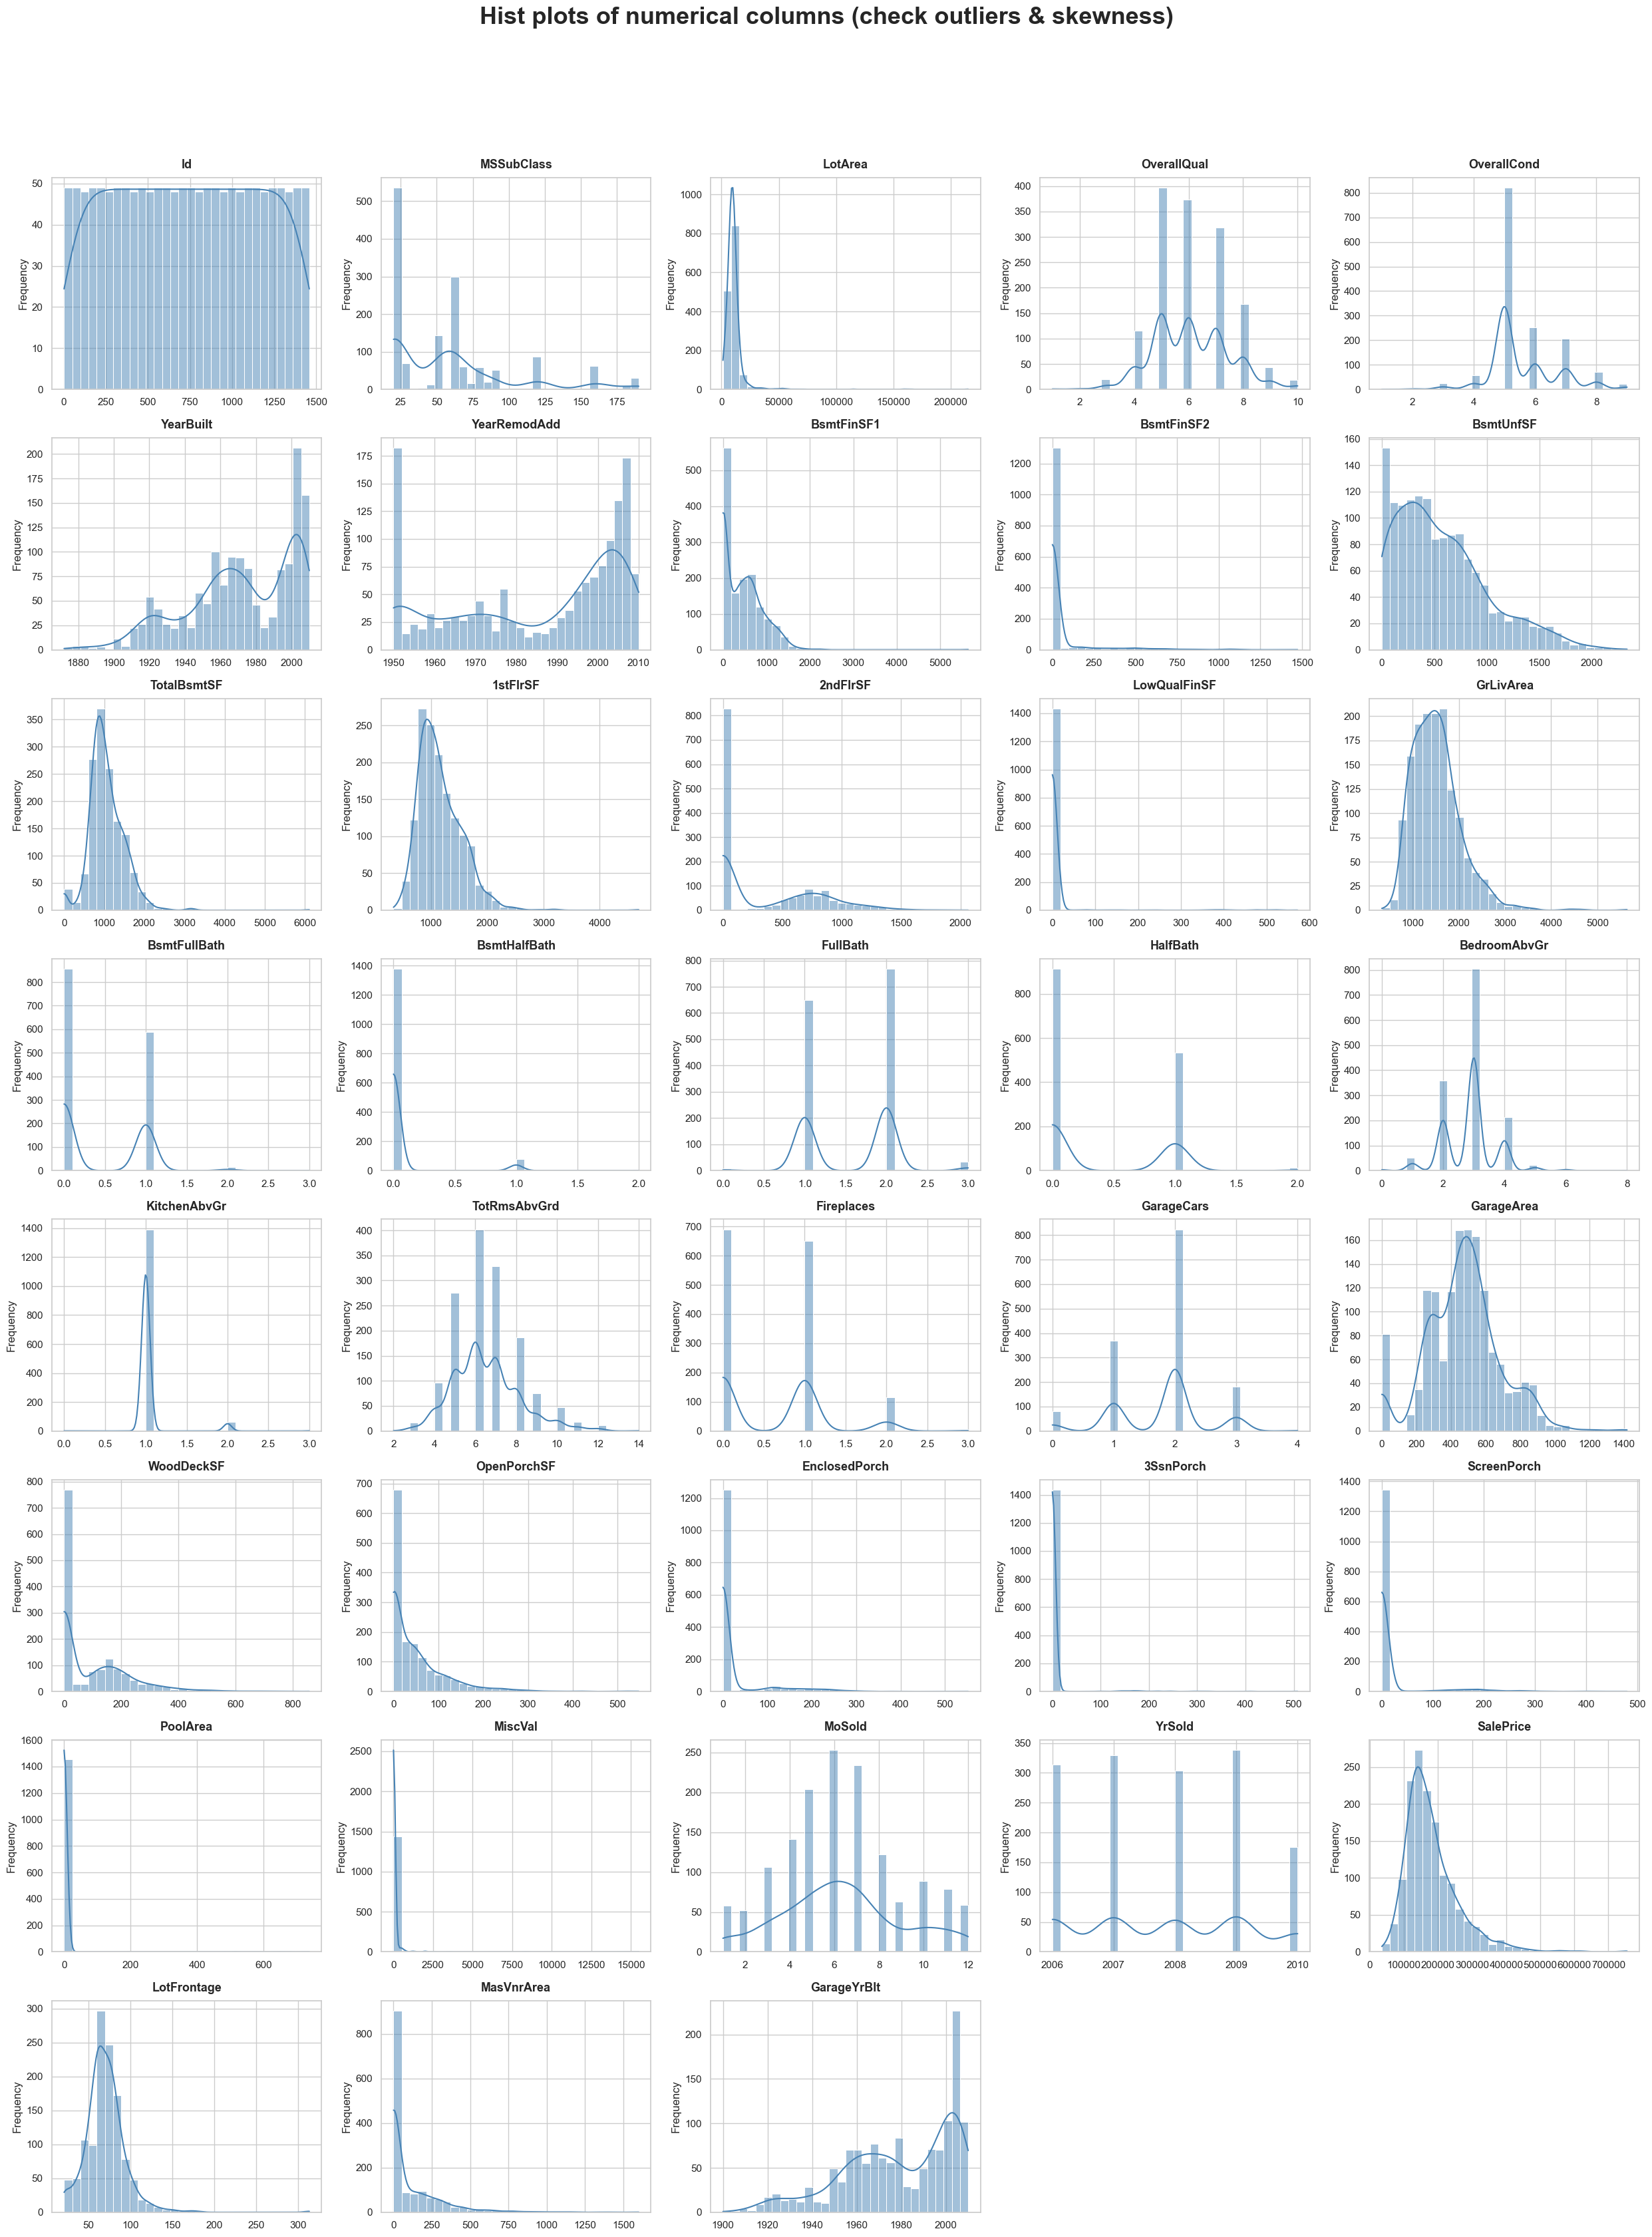

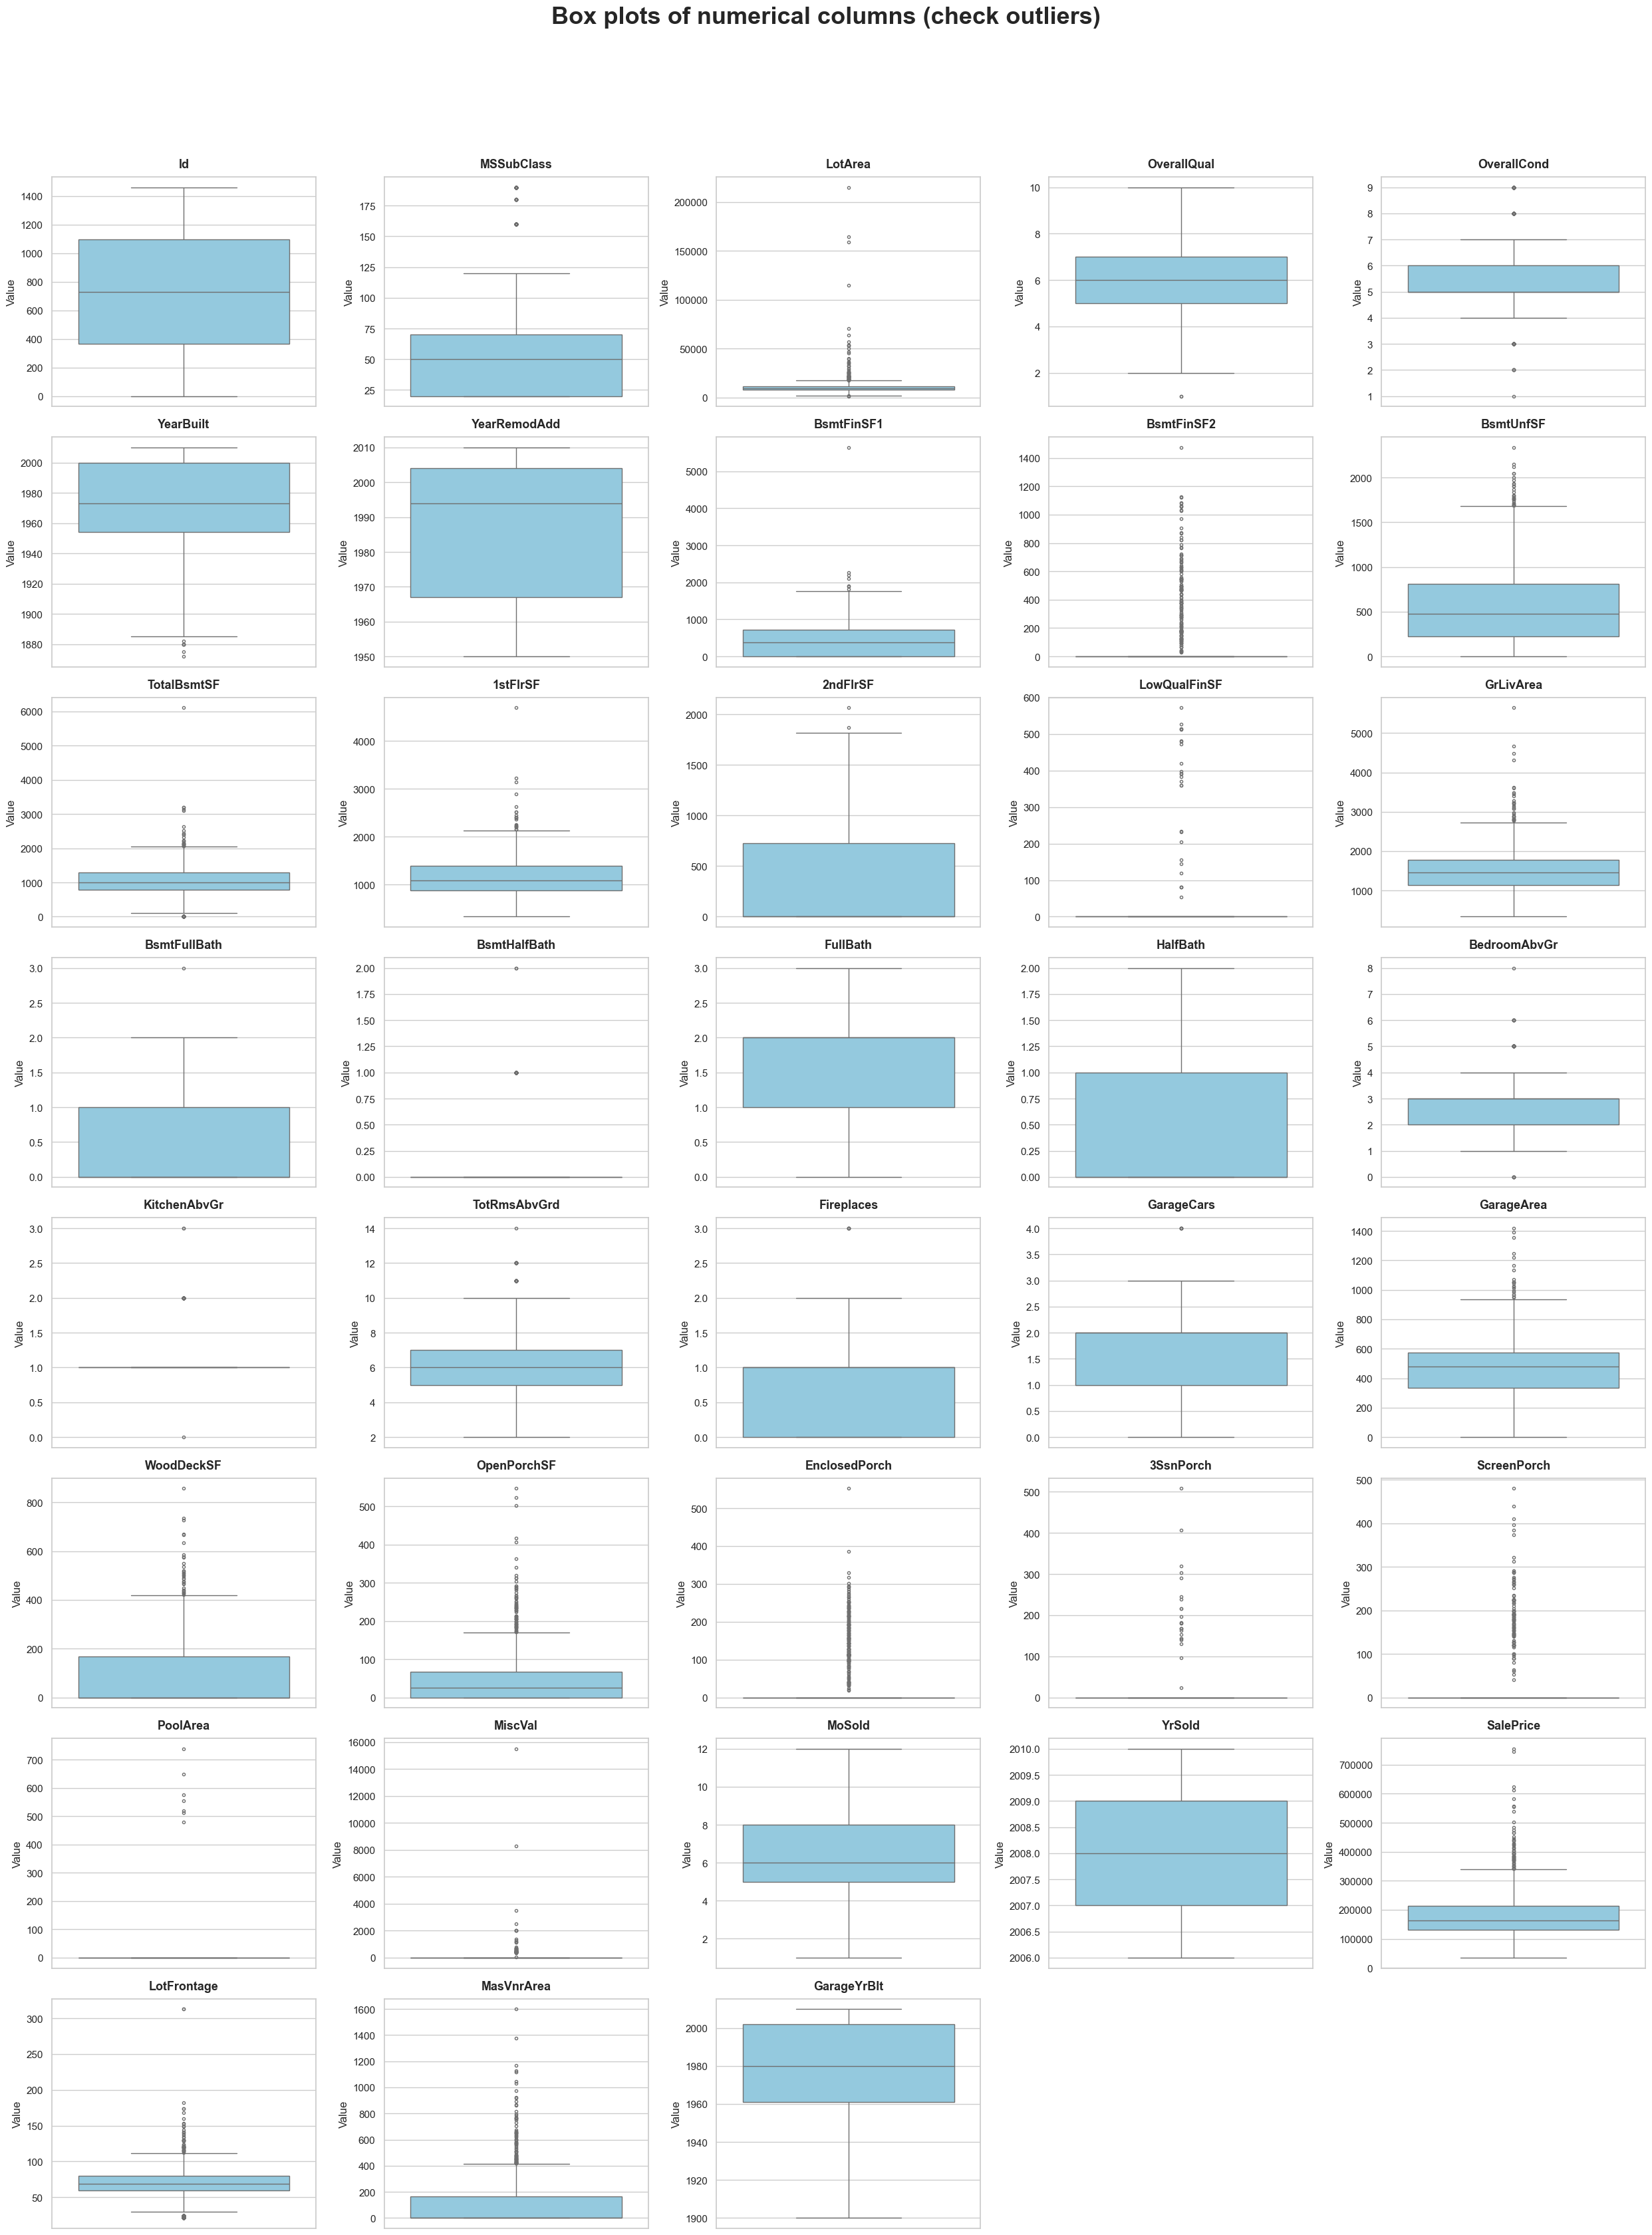

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


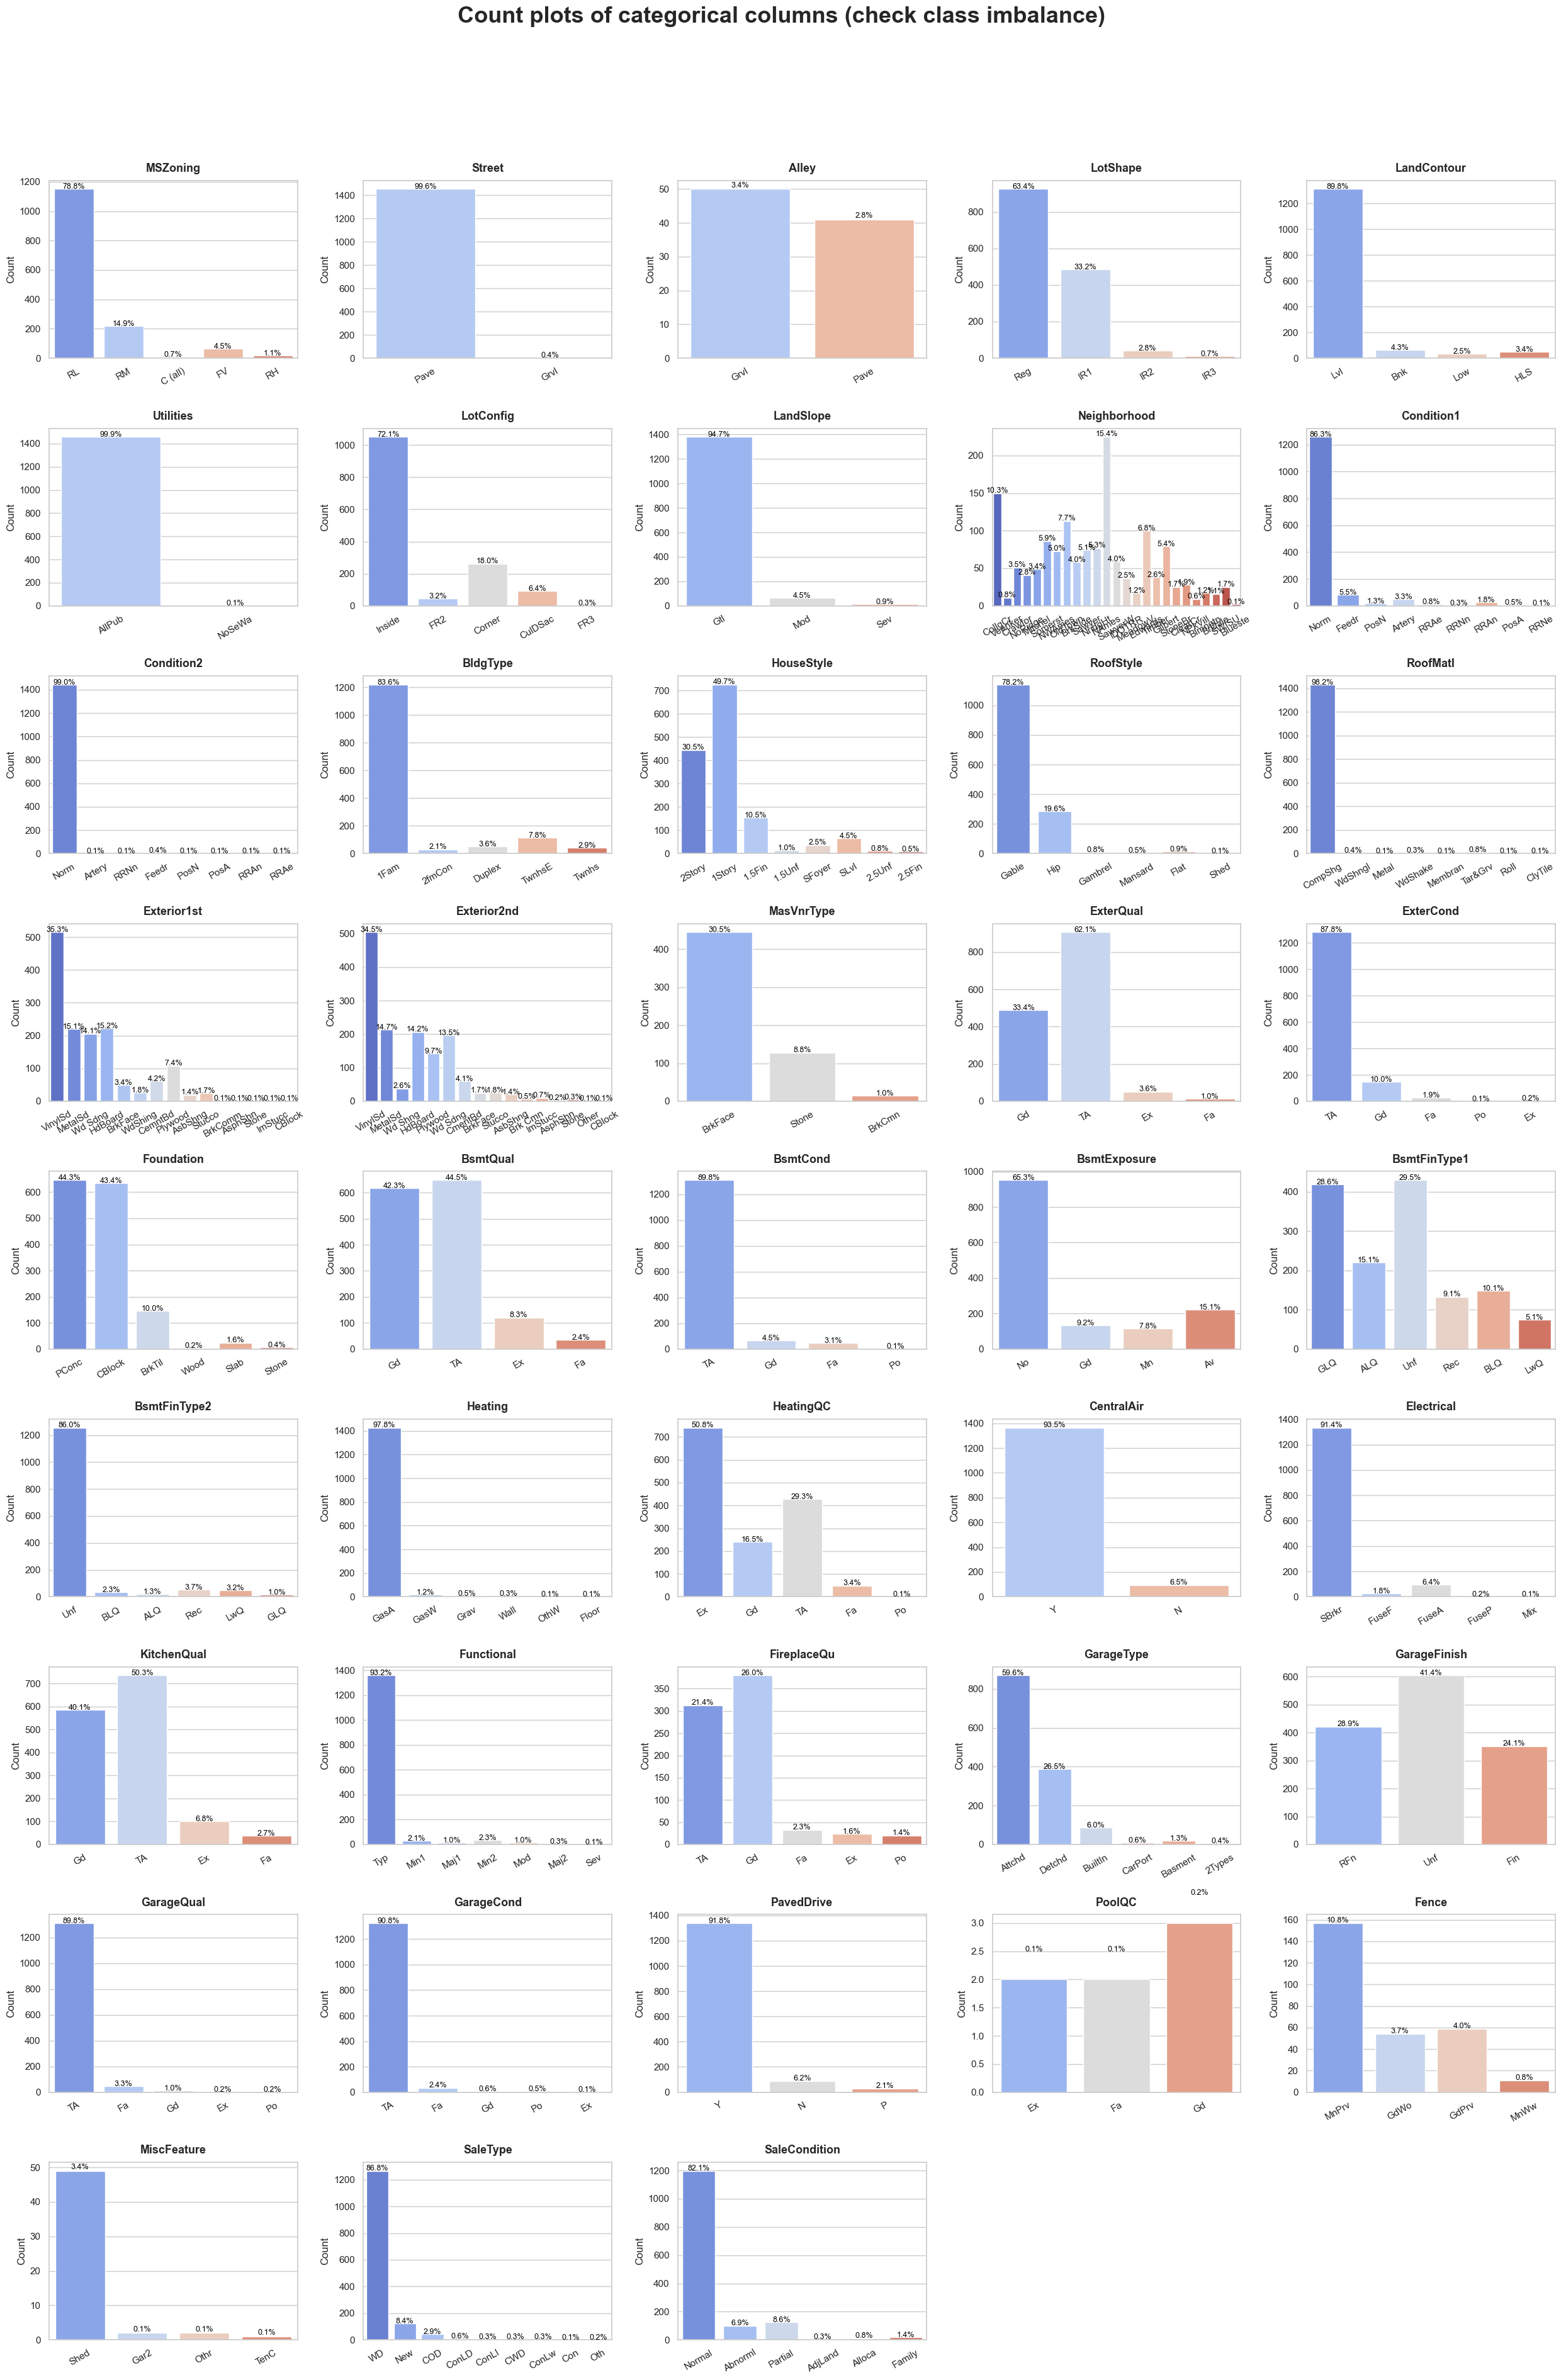

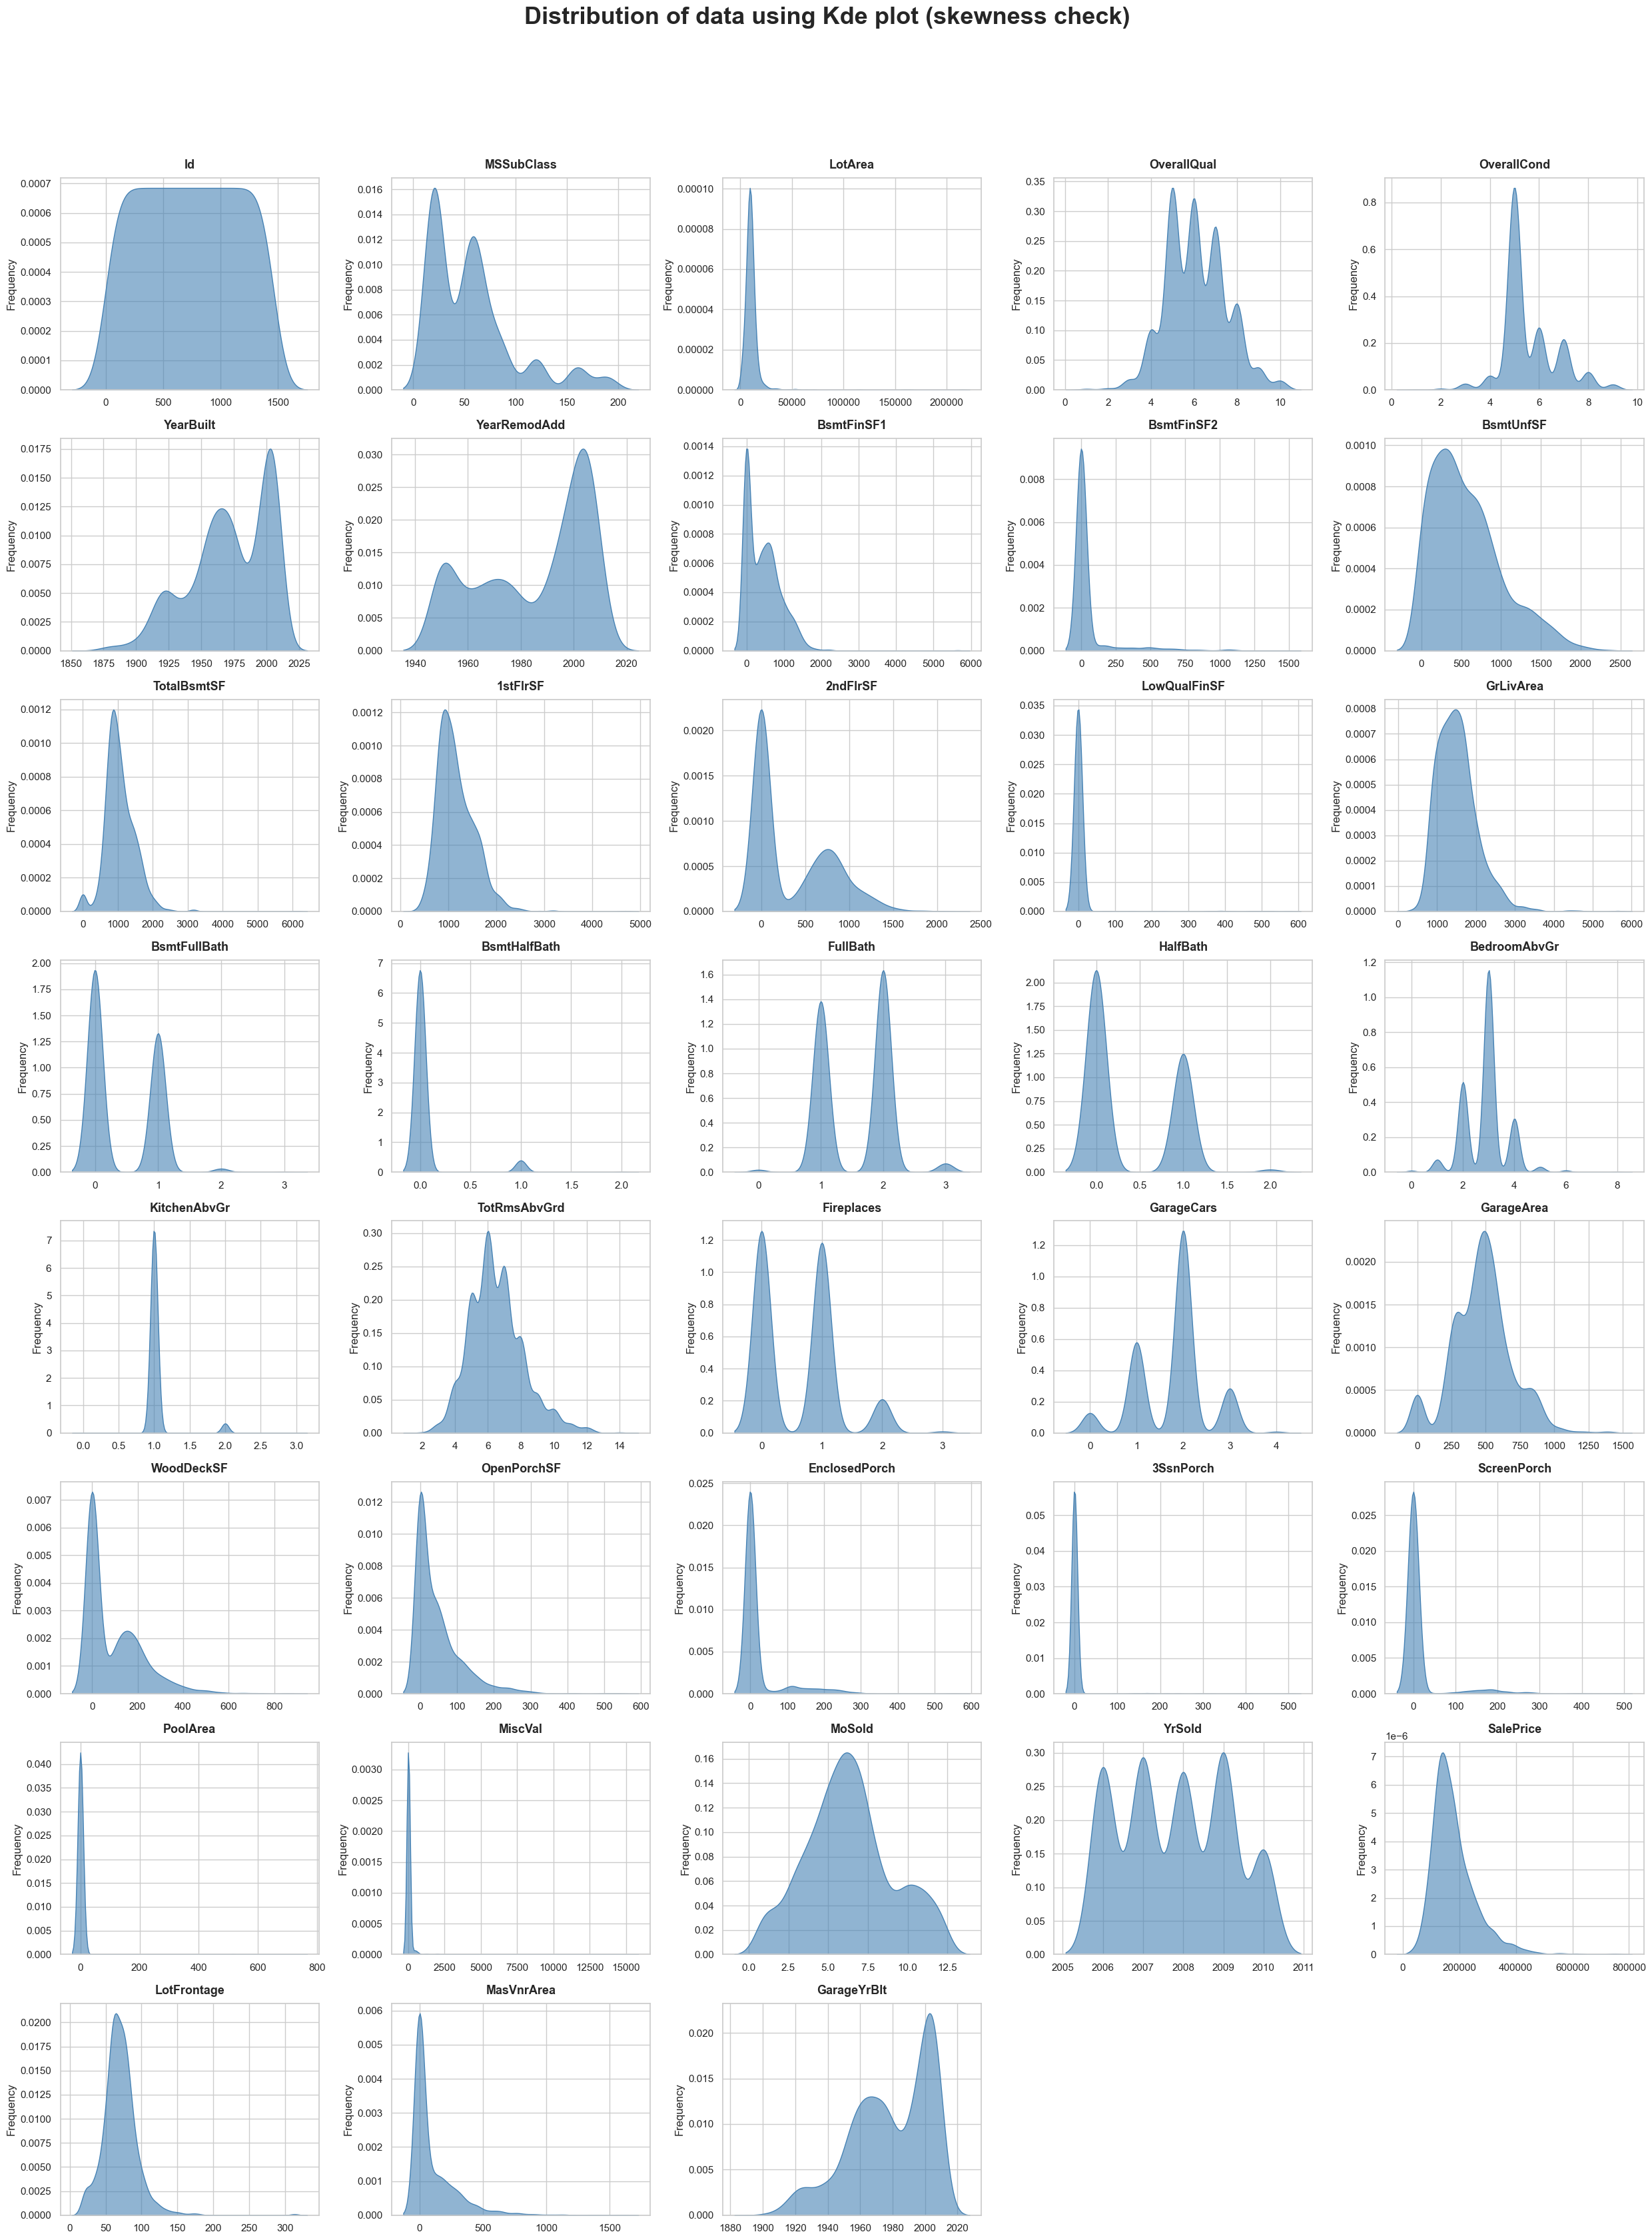

In [260]:
explore_shapes(df)
type_to_column = explore_types(df)
typeLevelSummary, columnLevelSummary = explore_null_or_missing(df, type_to_column)
explore_duplicates(df)
featuresUniqueValues = explore_unique_values(df, type_to_column)
constantcolumns = explore_constant_columns(featuresUniqueValues)
explore_univariate_skewness_outliers_histplots(df, type_to_column)
explore_univariate_outliers_boxplots(df, type_to_column)
explore_univariate_categorical_count_plots(df, type_to_column)
explore_univariate_skewness_kdeplot(df, type_to_column)